In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.resnet50 import ResNet50
from keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set directories for the dataset
train_dir = '/content/drive/My Drive/Colab Notebooks/datasets/train/train'
test_dir = '/content/drive/My Drive/Colab Notebooks/datasets/test/test'

In [ ]:
# Define image parameters
IMAGE_SIZE = [224, 224]

In [ ]:
# Image Data Generator for training
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

In [ ]:
!pip install tensorflow

In [ ]:
# Image Data Generator for training
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')


In [ ]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SIZE,
                                               batch_size=40,
                                               class_mode='categorical')

Found 2187 images belonging to 7 classes.


In [ ]:
# Image Data Generator for testing/validation
test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SIZE,
                                             batch_size=64,
                                             class_mode='categorical')

Found 564 images belonging to 7 classes.


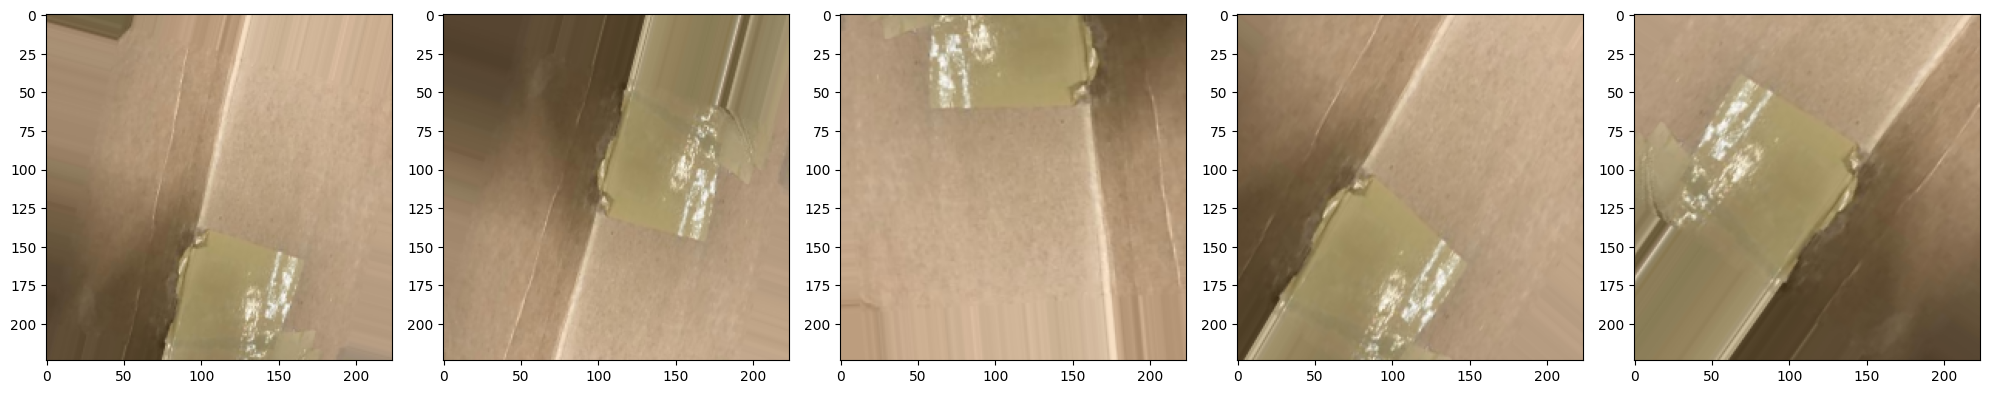

In [ ]:
import matplotlib.pyplot as plt

# Plotting function to display augmented images
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

# Show some augmented images from training data
images = [train_data[0][0][0] for i in range(5)]
plotImages(images)


In [ ]:
# Load the ResNet50 model
from keras.applications.resnet50 import ResNet50

resnet50_base = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Freeze the pre-trained layers
for layer in resnet50_base.layers:
    layer.trainable = False

In [ ]:
# Add custom layers on top of ResNet50
from keras.layers import Flatten, Dense
x = Flatten()(resnet50_base.output)
resnet50_prediction = Dense(train_data.num_classes, activation='softmax')(x)

In [ ]:
# Create the ResNet50 model
model_resnet50 = Model(inputs=resnet50_base.input, outputs=resnet50_prediction)


In [ ]:
# Compile the model
model_resnet50.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Print ResNet50 model summary
model_resnet50.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,290,183 (92.66 MB)

 Trainable params: 702,471 (2.68 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Callbacks for ResNet50
resnet50_checkpointer = ModelCheckpoint(filepath='resnet50_best_weights.keras', save_best_only=True, verbose=False)
resnet50_early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, mode='min')

In [ ]:
# Calculate steps per epoch and validation steps based on your dataset
steps_per_epoch = train_data.samples // train_data.batch_size
validation_steps = test_data.samples // test_data.batch_size

# Train the ResNet50 model
resnet50_history = model_resnet50.fit(
    train_data,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    callbacks=[resnet50_early_stop, resnet50_checkpointer],
    validation_data=test_data,
    validation_steps=validation_steps
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


54/54 ━━━━━━━━━━━━━━━━━━━━ 887s 15s/step - accuracy: 0.2008 - loss: 7.8594 - val_accuracy: 0.3223 - val_loss: 2.0228
Epoch 2/10
 1/54 ━━━━━━━━━━━━━━━━━━━━ 6:28 7s/step - accuracy: 0.3750 - loss: 1.8323

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 208ms/step - accuracy: 0.3750 - loss: 1.8323 - val_accuracy: 0.2115 - val_loss: 2.4741
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 579s 11s/step - accuracy: 0.2537 - loss: 2.4020 - val_accuracy: 0.2773 - val_loss: 2.2069
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 217ms/step - accuracy: 0.2500 - loss: 2.2051 - val_accuracy: 0.3269 - val_loss: 1.9745
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 579s 11s/step - accuracy: 0.2762 - loss: 2.0768 - val_accuracy: 0.3477 - val_loss: 1.7705
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 203ms/step - accuracy: 0.3750 - loss: 1.6531 - val_accuracy: 0.3654 - val_loss: 1.5989
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 577s 11s/step - accuracy: 0.3019 - loss: 1.9583 - val_accuracy: 0.2656 - val_loss: 2.5802
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 536ms/step - accuracy: 0.2250 - loss: 2.6635 - val_accuracy: 0.2885 - val_loss: 1.7739
Epoch 9/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 578s 10s/step - accuracy: 0.2911 - loss: 2.2171 - val_accuracy: 0.4238 - 

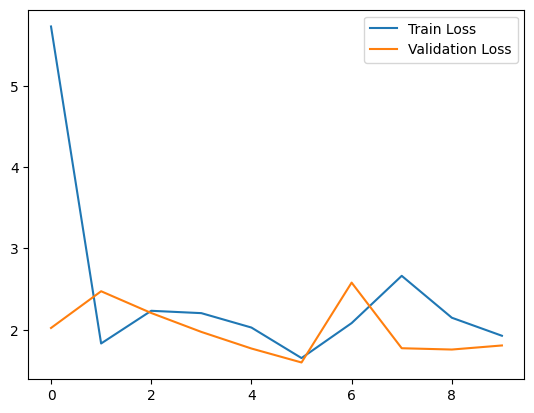

In [ ]:
# Plot training and validation loss for ResNet50
plt.plot(resnet50_history.history['loss'], label='Train Loss')
plt.plot(resnet50_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

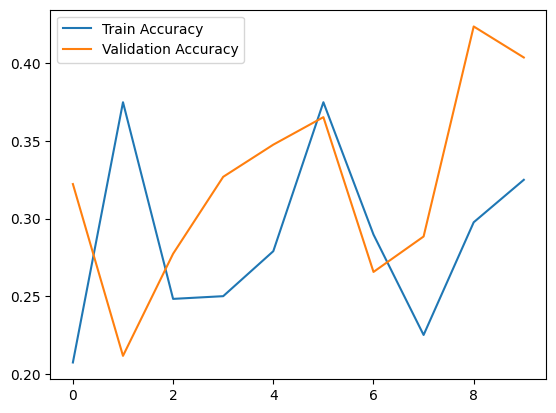

In [ ]:
# Plot training and validation accuracy for ResNet50
plt.plot(resnet50_history.history['accuracy'], label='Train Accuracy')
plt.plot(resnet50_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# Evaluate ResNet50 model on test data
resnet50_score = model_resnet50.evaluate(test_data)
print(f'ResNet50 Test Loss: {resnet50_score[0]}')
print(f'ResNet50 Test Accuracy: {resnet50_score[1]}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 114s 13s/step - accuracy: 0.4069 - loss: 1.6874
ResNet50 Test Loss: 1.666623592376709
ResNet50 Test Accuracy: 0.381205677986145


In [ ]:
### Saving and Downloading the Model ###

In [ ]:
from google.colab import files
# 1. Save and Download ResNet50 Model in .h5 Format
model_resnet50.save('resnet50_model.h5')
files.download('resnet50_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 2. Save and Download ResNet50 Model in .keras Format
model_resnet50.save('resnet50_model.keras')
files.download('resnet50_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle
# 3. Save and Download Resnet50 Model Weights in .pkl Format Using pickle
resnet50_weights = model_resnet50.get_weights()

with open('resnet50_weights.pkl', 'wb') as f:
    pickle.dump(resnet50_weights, f)

files.download('resnet50_weights.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Testing

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import tensorflow as tf

In [ ]:
# Load the saved model (update path to your model file)
model = tf.keras.models.load_model('/content/resnet50_model.h5', compile=False)

In [ ]:
# Load and preprocess the image (update path to your image file)
img = image.load_img('/content/drive/MyDrive/Colab Notebooks/datasets/test/test/cardboard/cardboard108.jpg', target_size=(224, 224))  # Ensure target size matches your model input
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0  # Normalize the image as done during training

In [ ]:
# Predict the class of the image
pred = model.predict(x)
pred_class = np.argmax(pred, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


In [ ]:
# Class labels (update based on your training classes)
index = ['cardboard','compost', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [ ]:
# Get the predicted class
result = str(index[pred_class[0]])
print(f'Predicted Class: {result}')

Predicted Class: cardboard


In [ ]:
# Loading keras file to Predict

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import os

In [6]:
# Load the pre-trained model from file
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/resnet50 new/resnet50_model (1).keras', compile=False)

In [7]:
def predict_image_class(image_path):
    """Predicts the class of an image from a file path."""
    if not os.path.exists(image_path):
        print(f"Error: Image file not found at {image_path}")
        return None

    # Load, preprocess, and predict
    img = image.load_img(image_path, target_size=(224, 224))
    x = np.expand_dims(image.img_to_array(img) / 255.0, axis=0)
    pred_class = np.argmax(model.predict(x), axis=1)

    # Class labels (adjust as needed)
    classes = ['cardboard', 'compost', 'glass', 'metal', 'paper', 'plastic', 'trash']
    return classes[pred_class[0]]

In [8]:
# Example usage
image_path = "/content/drive/MyDrive/Colab Notebooks/datasets/test/test/cardboard/cardboard108.jpg"
predicted_class = predict_image_class(image_path)

if predicted_class:
    print(f"Predicted Class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Class: cardboard
